<a href="https://colab.research.google.com/github/igamade/make-the-form/blob/master/%E4%B8%80%E7%95%AA%E6%9C%80%E5%88%9D%E3%81%AE%E6%96%B9%E3%80%80BATCH_SIZE_%3D_4%E3%80%80UTH_BERT_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UTH-BERT を Tensorflow2.X / Keras BERT から利用して文書分類を行う

公式サイト

- [BERT(Google)](https://github.com/google-research/bert)

- [UTH-BERT](https://ai-health.m.u-tokyo.ac.jp/uth-bert) \([東京大学 医療AI開発学講座](https://ai-health.m.u-tokyo.ac.jp/)\)

- [Keras BERT](https://github.com/CyberZHG/keras-bert)

## 必要なライブラリ等の準備

### pythonライブラリのインストールとインポート

In [1]:
!pip install keras_bert
!pip install mecab-python3
!pip install jaconv
!pip install neologdn

  Created wheel for keras-bert: filename=keras_bert-0.86.0-cp37-none-any.whl size=34144 sha256=43fd5af834822a0ae3fafbc5b4bae9ba26679bd2ba6363a7c93afddfc6dac102
  Stored in directory: /root/.cache/pip/wheels/66/f0/b1/748128b58562fc9e31b907bb5e2ab6a35eb37695e83911236b
  Created wheel for keras-transformer: filename=keras_transformer-0.38.0-cp37-none-any.whl size=12942 sha256=d76e3192c983da5f0288dd62bac3ee63635ae34a9008f118c491a6981f33a6b6
  Stored in directory: /root/.cache/pip/wheels/e5/fb/3a/37b2b9326c799aa010ae46a04ddb04f320d8c77c0b7e837f4e
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp37-none-any.whl size=7554 sha256=55bff4a7625d908189d992dcd982f10906c5f0c2f01a81bab0fdb8ca04ad6e88
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.27.0-cp37-none-any.whl size=15611 sha256=a2af09a95d9770f4ef5de8a05a3c7211bbc40625c220e9f4895695323cbbb5f7
  Stor

In [2]:
import os, sys
import tensorflow as tf
import pandas as pd 
import numpy as np
import keras_bert

In [3]:
# tensorflowのバージョンを確認(2.3.0で動作確認済み)
tf.__version__  

'2.4.1'

In [4]:
# Keras BERTのバージョンを確認（0.86.0で動作確認済み）
keras_bert.__version__

'0.86.0'

In [5]:
# Keras BERT で tf.keras を使用するための環境変数を設定
os.environ['TF_KERAS'] = '1'

### その他のライブラリとデータセットのダウンロードとインストール

In [6]:
# UTH-BERT
!wget https://ai-health.m.u-tokyo.ac.jp/labweb/dl/uth_bert/UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K.zip
!unzip UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K.zip
!rm UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K.zip
!git clone https://github.com/jinseikenai/uth-bert.git

# MeCab & NEologd
!apt install mecab libmecab-dev mecab-ipadic-utf8 file
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -a -y # 公式では -a オプションはついていないが多分必要
os.environ['MECABRC'] = "/etc/mecabrc" # 環境変数でmecabrcの場所を指定

# 万病辞書
!wget http://sociocom.jp/~data/2018-manbyo/data/MANBYO_201907_Dic-utf8.dic

# KNBコーパス
!wget http://nlp.ist.i.kyoto-u.ac.jp/kuntt/KNBC_v1.0_090925_utf8.tar.bz2
!tar -jxvf KNBC_v1.0_090925_utf8.tar.bz2
!rm KNBC_v1.0_090925_utf8.tar.bz2

ストリーミング出力は最後の 5000 行に切り捨てられました。
KNBC_v1.0_090925_utf8/html/KN208_Kyoto_1-1-18-01-morph.html
KNBC_v1.0_090925_utf8/html/KN218_Gourmet_1-1-3-01.html
KNBC_v1.0_090925_utf8/html/KN221_Keitai_1-1-12-01-morph.html
KNBC_v1.0_090925_utf8/html/KN012_Sports_2-1-31-01.html
KNBC_v1.0_090925_utf8/html/KN215_Kyoto_1-1-26-01.html
KNBC_v1.0_090925_utf8/html/KN213_Keitai_1-1-3-01-morph.html
KNBC_v1.0_090925_utf8/html/KN039_Kyoto_1-1-28-01-morph.html
KNBC_v1.0_090925_utf8/html/KN238_Gourmet_1-1-26-01-morph.html
KNBC_v1.0_090925_utf8/html/KN217_Kyoto_1-1-20-01.html
KNBC_v1.0_090925_utf8/html/KN242_Kyoto_2-1-20-01.html
KNBC_v1.0_090925_utf8/html/KN209_Keitai_1-1-56-01-morph.html
KNBC_v1.0_090925_utf8/html/KN255_Kyoto_1-1-8-01-morph.html
KNBC_v1.0_090925_utf8/html/KN258_Keitai_1-1-8-02-morph.html
KNBC_v1.0_090925_utf8/html/KN002_Keitai_1-1-2-01-morph.html
KNBC_v1.0_090925_utf8/html/KN025_Kyoto_1-1-7-01-morph.html
KNBC_v1.0_090925_utf8/html/KN243_Gourmet_1-1-7-01-morph.html
KNBC_v1.0_090925_utf8/html/KN205_

## ディレクトリ・ファイルへのパスを設定

In [7]:
# データセット
knbc_dir_path = '/content/'
gourmet_tsv_file_path = os.path.join(knbc_dir_path, 'reduced_MCI.tsv')
keitai_tsv_file_path = os.path.join(knbc_dir_path, 'reduced_Healthy.tsv')

# 訓練済みモデル
pretrained_model_dir_path = 'UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K'
pretrained_bert_config_file_path = os.path.join(pretrained_model_dir_path, 'bert_config.json')
pretrained_model_checkpoint_path = os.path.join(pretrained_model_dir_path, 'model.ckpt-352000') # 拡張子不要
pretrained_vocab_file_path = os.path.join(pretrained_model_dir_path, 'vocab.txt')

# 今回学習するモデル
!mkdir train_model
train_model_dir_path = 'train_model'
train_bert_config_file_path = os.path.join(train_model_dir_path, 'train_bert_config.json')
train_model_checkpoint_path = os.path.join(train_model_dir_path, 'train_model.ckpt')

# NEologd辞書ディレクトリへのパス
import subprocess
cmd = 'echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
neologd_dic_dir_path = subprocess.check_output(cmd, shell=True).decode('utf-8').strip()

# 万病辞書へのパス
manbyo_dic_path = 'MANBYO_201907_Dic-utf8.dic'

In [8]:
print (gourmet_tsv_file_path)

/content/reduced_MCI.tsv


## KNBコーパスから今回用いるデータを抽出

In [9]:
# 各カテゴリのtsvファイルを読み込んでラベル列を追加
df_gourmet = pd.read_table(gourmet_tsv_file_path, header=None)
df_gourmet['label'] = 'MCI'

df_keitai = pd.read_table(keitai_tsv_file_path, header=None)
df_keitai['label'] = 'Healthy'

# df_kyoto = pd.read_table(kyoto_tsv_file_path, header=None)
# df_kyoto['label'] = '京都観光'

# df_sports = pd.read_table(sports_tsv_file_path, header=None)
# df_sports['label'] = 'スポーツ'

# 結合して必要な列だけ抽出
# df_dataset = pd.concat([df_gourmet, df_keitai, df_kyoto, df_sports])[[1, 'label']]
df_dataset = pd.concat([df_gourmet, df_keitai])[[1, 'label']]
df_dataset.columns = ['text', 'label'] # ラベル名変更
df_dataset

,text,label
0,今から１年以上前なんですが えー 父親の弟 いわゆる叔父ですね えー この方が亡くなりまして...,MCI
1,今から１年以上前なですがえー父親の弟いわゆる叔父ですねえーこの方が亡くなりましてえーその年前...,MCI
2,今から１年以上前なんですえー父親の弟いわゆるですえーこの方がましてえーその１年前にも叔母が亡...,MCI
3,今から１連続以上前なんですがえー父親の弟いわゆる叔父ですねえーこの方が亡くなりましてえーその...,MCI
4,今１年以上前なんですが父親の弟いわゆる叔父ですねえーこの方が亡くなりましてえーその１年前にも...,MCI
...,...,...
5395,はいえっとよく分からないいうだったんですが２ぶつかりですし鹿ですか犬ですかねえーと歩い鹿行っ...,Healthy
5396,はいえっとよく分からないアニメだった散策んですが２匹のし鹿仰しゃるですか犬ですかねえーと歩い...,Healthy
5397,はいえっとよく分からないアニメだったんですが２匹のし牡鹿ですか飼い犬ですかねえーと歩いて行っ...,Healthy
5398,はいえっとよく分からないアニメだったんですが２匹のし鹿ですか犬ですかねえーと歩い林て行って雄...,Healthy


### 学習用データとテスト用データに分割

In [10]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_dataset, test_size=0.2)

## 前処理用プログラムの動作確認

Tensorflow 2.X では tokenization_mod.py の tf.gfile.GFile を tf.io.gfile.GFile に変更しないとエラーになるので書き換える

In [11]:
# sed コマンドで tf.gfile.GFile を tf.io.gfile.GFile に置換
!sed -i-e 's/tf\.gfile\.GFile/tf\.io\.gfile\.GFile/g' ./uth-bert/tokenization_mod.py

https://github.com/jinseikenai/uth-bert の [example_main.py](https://github.com/jinseikenai/uth-bert/blob/master/example_main.py) の内容が実行できることを確認

In [12]:
sys.path.append('uth-bert')
from preprocess_text import preprocess as my_preprocess
from tokenization_mod import MecabTokenizer, FullTokenizerForMecab

if __name__ == '__main__':

    # special token for a Person's name (Do not change)
    name_token = "＠＠Ｎ"

    # path to the mecab-ipadic-neologd
    #mecab_ipadic_neologd = '/usr/lib/mecab/dic/mecab-ipadic-neologd' # 変更
    mecab_ipadic_neologd = neologd_dic_dir_path

    # path to the J-Medic (We used MANBYO_201907_Dic-utf8.dic)
    #mecab_J_medic = './MANBYO_201907_Dic-utf8.dic' # 変更
    mecab_J_medic = manbyo_dic_path

    # path to the uth-bert vocabulary
    #vocab_file = "./bert_vocab_mc_v1_25000.txt" # 変更
    vocab_file = pretrained_vocab_file_path

    # MecabTokenizer
    sub_tokenizer = MecabTokenizer(mecab_ipadic_neologd=mecab_ipadic_neologd,
                                   mecab_J_medic=mecab_J_medic,
                                   name_token=name_token)

    # FullTokenizerForMecab
    tokenizer = FullTokenizerForMecab(sub_tokenizer=sub_tokenizer,
                                      vocab_file=vocab_file,
                                      do_lower_case=False)

    # pre-process and tokenize example
    original_text = "2002 年夏より重い物の持ち上げが困難になり，階段の昇りが遅くなるなど四肢の筋力低下が緩徐に進行した．2005 年 2 月頃より鼻声となりろれつが回りにくくなった．また，食事中にむせるようになり，同年 12 月に当院に精査入院した。"
    print ('・Original text\n', original_text, end='\n\n')

    pre_processed_text = my_preprocess(original_text)
    print ('・After pre-processing\n', pre_processed_text, end='\n\n')

    output_tokens = tokenizer.tokenize(pre_processed_text)
    print ('・After tokenization\n', output_tokens)

・Original text
 2002 年夏より重い物の持ち上げが困難になり，階段の昇りが遅くなるなど四肢の筋力低下が緩徐に進行した．2005 年 2 月頃より鼻声となりろれつが回りにくくなった．また，食事中にむせるようになり，同年 12 月に当院に精査入院した。

・After pre-processing
 ２００２年夏より重い物の持ち上げが困難になり、階段の昇りが遅くなるなど四肢の筋力低下が緩徐に進行した．２００５年２月頃より鼻声となりろれつが回りにくくなった．また、食事中にむせるようになり、同年１２月に当院に精査入院した。

・After tokenization
 ['２００２年', '夏', 'より', '重い', '物', 'の', '持ち上げ', 'が', '困難', 'に', 'なり', '、', '階段', 'の', '[UNK]', 'が', '遅く', 'なる', 'など', '四肢', 'の', '筋力低下', 'が', '緩徐', 'に', '進行', 'し', 'た', '．', '２００５年', '２', '月頃', 'より', '鼻', '##声', 'と', 'なり', 'ろ', '##れ', '##つ', 'が', '回り', '##にく', '##く', 'なっ', 'た', '．', 'また', '、', '食事', '中', 'に', 'むせる', 'よう', 'に', 'なり', '、', '同年', '１２月', 'に', '当', '院', 'に', '精査', '入院', 'し', 'た', '。']


## 前処理を実行

### PreprocessingとTokenizationを学習用データとテスト用データに適用

In [13]:
def preprocess_text(s):
    result = []
    for text in s:
        result.append(my_preprocess(text))

    return result

In [14]:
train_text_preprocessed = preprocess_text(df_train['text'])
test_text_preprocessed = preprocess_text(df_test['text'])


# 先頭3つのデータを表示
for i in range(3):
    print(train_text_preprocessed[i])

お兄ちゃんが乗っている椅子が不安定ですから危険ですそれからもう一つはお母さんがあの洗い事をしているんですけども水道の水がこぼれだしていることです．．．あとはお母さんがだいどこをやっているんですけどもその顔がお皿か何とかに映ってるとお皿がちゃんと置いてないこういうことですね．．．何か．．．まそんなとこですねはい．．．それからあのー流しの水があのー栓をしたまま流しているからだいどこにこぼれ落ちているうーん．．．
ある家庭の１日ある時間ことですお母さんはお皿を洗っていますが何か考え事をているらしくてぼーっとしてお水は水道から水がジャブジャブ出て床に流れ落ちています子どもは２人で男の子と女の子いて男の子が椅子を持ってきて高いところのえー高いところ置いてあるお菓子ですかこれを取ろうとして何か椅子が傾いています今にも落ちそうですで妹さんかな妹が「早くそのお菓子ちょうだい」て言っいます何かお母さんはぼーっとしてお水を出しっ放ししてお皿をふいてる子どもたち人は男の子は今にも倒れそうな椅子の上に乗っては早くお菓子ちょうだいって言ってそういうことが起きています
え次はあなたの懼れるする人について教えて給るとゆう事でございますわたくしがえー懼れるする人とは今わたくし自身がえー書道を習っておりますその教官でございますその教官はえーま教官とゆうかその会そのものがえー自分で漢詩を作りそして自分でえー書を起草自詠じしょ自書とゆうえー会でございますそしてその教官の作り上げる漢詩は異常にこう人を感動させる温かい漢詩を作っていらっしゃるますそして書もやはり凄いんですねあのー凄いと言ってもここじゃ言い表せませんけども異常にあのー見てて素晴らしい詩ですそしてわたくしどもがえー展覧会に出すためにえ書いていきますともうお年は８０＊＊になるんですけども何かこの字違うよと言って指摘してくれますそれを事典で調べますと大体もう相異なるてるんですねそういうなぱっぱと存じるいやー凄いなと思いますねあのー書体関係なしに存じるんですね大した教官だと思います懼れるしております


- Tokenization時に[CLS] と [SEP]を付加する

In [15]:
def tokenize_text(s):
    result = []
    for text in s:
        result.append(['[CLS]'] + tokenizer.tokenize(text) + ['[SEP]'])

    return result

In [16]:
train_text_tokenized = tokenize_text(df_train['text'])
test_text_tokenized = tokenize_text(df_test['text'])

# 先頭3つのデータを表示
for i in range(3):
    print(train_text_tokenized[i])

['[CLS]', 'お', '##兄', '##ちゃ', '##ん', 'が', '乗っ', 'て', 'いる', '椅子', 'が', '不安定', 'です', 'から', '危険', 'です', 'それから', 'もう', '一つ', 'は', 'お母さん', 'が', 'あの', '洗', 'い事', 'を', 'し', 'て', 'いる', 'ん', 'です', 'けど', '##も', '水', '##道', 'の', '水', 'が', 'こぼれ', 'だし', 'て', 'いる', 'こと', 'です', '[UNK]', 'あと', 'は', 'お母さん', 'が', '##だい', 'どこ', 'を', 'やっ', 'て', 'いる', 'ん', 'です', 'けど', '##も', 'その', '顔', 'が', 'お', '皿', 'か', '何とか', 'に', '[UNK]', 'てる', 'と', 'お', '皿', 'が', 'ちゃんと', '置い', 'て', 'ない', 'こういう', 'こと', 'です', 'ね', '[UNK]', '何', 'か', '[UNK]', 'ま', 'そんな', 'とこ', 'です', 'ね', 'はい', '[UNK]', 'それから', 'あの', '##ー', '流し', 'の', '水', 'が', 'あの', '##ー', '栓', 'を', 'し', 'た', 'まま', '流し', 'て', 'いる', 'から', 'だい', 'どこ', 'に', 'こぼれ', '##落ち', 'て', 'いる', 'うーん', '[UNK]', '[SEP]']
['[CLS]', 'ある', '家庭', 'の', '１日', 'ある時', '間', 'こと', 'です', 'お母さん', 'は', 'お', '皿', 'を', '洗っ', 'て', 'い', 'ます', 'が', '何', 'か', '考え', '##事', 'を', 'て', 'いる', 'らしく', 'て', 'ぼーっ', 'として', 'お水', 'は', '水', '##道', 'から', '水', 'が', 'ジ', '##ャ', '##ブ', '##ジャ', '##ブ', '出て', '床', 'に', '流れ',

### 入力データの最大長を算出

In [17]:
# ファインチューニングする場合は学習データ・テストデータの最大長を用いる
maxlen = 0

for tokens in train_text_tokenized:
    maxlen = max(maxlen, len(tokens))

for tokens in test_text_tokenized:
    maxlen = max(maxlen, len(tokens))

maxlen

print(maxlen)

367


### テキストをトークン列から単語ID列に変換

In [18]:
def tokens_to_ids(tokenized_text):
    result = []
    for tokens in tokenized_text:
        result.append(tokenizer.convert_tokens_to_ids(tokens))

    return result

In [19]:
train_text_ids = tokens_to_ids(train_text_tokenized)
test_text_ids = tokens_to_ids(test_text_tokenized)

# 先頭3つのデータを表示
for i in range(3):
    print(train_text_ids[i])

[2, 291, 20916, 9200, 2802, 18, 6715, 13, 39, 3379, 18, 4514, 63, 55, 1864, 63, 10887, 674, 4411, 15, 5278, 18, 4282, 7692, 10543, 25, 16, 13, 39, 115, 63, 248, 2602, 707, 7065, 10, 707, 18, 18851, 3053, 13, 39, 48, 63, 1, 1162, 15, 5278, 18, 13721, 2510, 25, 881, 13, 39, 115, 63, 248, 2602, 327, 1843, 18, 291, 15411, 74, 3955, 14, 1, 435, 27, 291, 15411, 18, 3105, 3140, 13, 42, 7874, 48, 63, 128, 1, 518, 74, 1, 1875, 3339, 5747, 63, 128, 1739, 1, 10887, 4282, 2023, 5523, 10, 707, 18, 4282, 2023, 9772, 25, 16, 19, 894, 5523, 13, 39, 55, 18336, 2510, 14, 18851, 10577, 13, 39, 4483, 1, 3]
[2, 58, 6511, 10, 84, 6458, 962, 48, 63, 5278, 15, 291, 15411, 25, 7012, 13, 66, 57, 18, 518, 74, 170, 5702, 25, 13, 39, 12295, 13, 6485, 247, 7510, 15, 707, 7065, 55, 707, 18, 7588, 24225, 3255, 7549, 3255, 2050, 1773, 14, 3270, 10577, 13, 66, 57, 7596, 15, 3415, 21, 5644, 1366, 4864, 2545, 13241, 1366, 4864, 66, 13, 5644, 1366, 4864, 18, 3379, 25, 1373, 13, 197, 13, 558, 261, 10, 11191, 558, 261, 3140

### 単語ID列をリストからnumpy arrayに変換

In [20]:
def list_to_numpy_array(input_list, maxlen):
    result = np.zeros((len(input_list), maxlen), dtype=np.int32)

    for i in range(len(input_list)):
        for j in range(len(input_list[i])):
            result[i][j] = input_list[i][j]

    return result

In [21]:
X_train = list_to_numpy_array(train_text_ids, maxlen)
X_test = list_to_numpy_array(test_text_ids, maxlen)

# 先頭3つのデータを表示
X_train[:3]

array([[    2,   291, 20916, ...,     0,     0,     0],
       [    2,    58,  6511, ...,     0,     0,     0],
       [    2,  1145,  2328, ...,     0,     0,     0]], dtype=int32)

### ラベルデータを入力形式に変換

kerasのクラス分類のラベルデータはOne-hotエンコーディング

In [22]:
# ラベル -> インデックス の対応
label2index = {k: i for i, k in enumerate(df_train['label'].unique())}

# インデックス -> ラベル の対応
index2label = {i: k for i, k in enumerate(df_train['label'].unique())}

# ラベルの分類クラス数
class_count = len(label2index)
print('class count = ', class_count)

# One-hot encoding
y_train = tf.keras.utils.to_categorical([label2index[label] for label in df_train['label']], num_classes=class_count)
y_test = tf.keras.utils.to_categorical([label2index[label] for label in df_test['label']], num_classes=class_count)

# 先頭3つのデータを表示
print(y_train[:3])

class count =  2
[[1. 0.]
 [1. 0.]
 [1. 0.]]


## コンフィグファイルの準備

### 訓練済みモデルのBERTコンフィグファイルをロード

In [23]:
import json
from pprint import pprint as pp

json_open = open(pretrained_bert_config_file_path, 'r')
pretrained_bert_config =json.load(json_open)

pp(pretrained_bert_config)

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 25000}


### 学習用BERTコンフィグファイルを作成

max_position_embedding と max_seq_length を今回使用するデータのトークンの最大長に設定する

In [24]:
# train_bert_config = pretrained_bert_config

train_bert_config = pretrained_bert_config
train_bert_config['max_position_embeddings'] = maxlen
train_bert_config['max_seq_length'] = maxlen

pp(train_bert_config)

# jsonファイルとして保存
with open(train_bert_config_file_path, 'w') as f:
    json.dump(train_bert_config, f, indent=4)

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 367,
 'max_seq_length': 367,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 25000}


## 学習

### 学習パラメータの設定

In [31]:
# BATCH_SIZE = 16
BATCH_SIZE = 4
EPOCHS = 20
LR = 1e-4

### 訓練済みBERTモデルのロード

In [26]:
from keras_bert import load_trained_model_from_checkpoint
bert = load_trained_model_from_checkpoint(train_bert_config_file_path, pretrained_model_checkpoint_path, training=True, trainable=True, seq_len=maxlen)
bert.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 367)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 367)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 367, 768), ( 19200000    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 367, 768)     1536        Input-Segment[0][0]              
______________________________________________________________________________________________

### 学習用モデルの定義

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional
from keras_bert import AdamWarmup, calc_train_steps

def _create_model(bert, maxlen, class_count):
    bert_last = bert.get_layer(name='NSP-Dense').output #  NSP-Denseを指定する理由は要確認
    output_tensor = Dense(class_count, activation='softmax')(bert_last)

    model = Model([bert.input[0], bert.input[1]], output_tensor)

    decay_steps, warmup_steps = calc_train_steps(
        maxlen,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
    )

    # optimizer='nadam' では収束しないのでAdamWarmupを用いる
    model.compile(
        loss='categorical_crossentropy',
        optimizer=AdamWarmup(decay_steps=decay_steps, warmup_steps=warmup_steps, lr=LR),
        metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

In [33]:
model = _create_model(bert, maxlen, class_count)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 367)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 367)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 367, 768), ( 19200000    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 367, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

### 学習を実行

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

history = model.fit(
    [X_train, np.zeros_like(X_train)],
    y_train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_split=0.1,
    shuffle=True,
    verbose = 1,
    callbacks = [
        EarlyStopping(patience=5, monitor='val_acc', mode='max'),
        ModelCheckpoint(monitor='val_acc', mode='max', filepath=train_model_checkpoint_path, save_best_only=True)
    ]
)

Epoch 1/20
1944/1944 [==============================] - 711s 350ms/step - loss: 0.4813 - acc: 0.7310 - precision_1: 0.7310 - recall_1: 0.7310 - val_loss: 0.0096 - val_acc: 0.9977 - val_precision_1: 0.9977 - val_recall_1: 0.9977
INFO:tensorflow:Assets written to: train_model/train_model.ckpt/assets
Epoch 2/20
1944/1944 [==============================] - 691s 355ms/step - loss: 0.0048 - acc: 0.9990 - precision_1: 0.9990 - recall_1: 0.9990 - val_loss: 0.0096 - val_acc: 0.9977 - val_precision_1: 0.9977 - val_recall_1: 0.9977
Epoch 3/20
1944/1944 [==============================] - 691s 355ms/step - loss: 0.0050 - acc: 0.9988 - precision_1: 0.9988 - recall_1: 0.9988 - val_loss: 0.0096 - val_acc: 0.9977 - val_precision_1: 0.9977 - val_recall_1: 0.9977
Epoch 4/20
1944/1944 [==============================] - 692s 356ms/step - loss: 0.0074 - acc: 0.9980 - precision_1: 0.9980 - recall_1: 0.9980 - val_loss: 0.0096 - val_acc: 0.9977 - val_precision_1: 0.9977 - val_recall_1: 0.9977
Epoch 5/20
1944/1

In [35]:
pd.DataFrame(history.history)

,loss,acc,precision_1,recall_1,val_loss,val_acc,val_precision_1,val_recall_1
0,0.249420,0.873071,0.873071,0.873071,0.009596,0.997685,0.997685,0.997685
1,0.005284,0.998843,0.998843,0.998843,0.009596,0.997685,0.997685,0.997685
2,0.006004,0.998328,0.998328,0.998328,0.009596,0.997685,0.997685,0.997685
3,0.006279,0.998457,0.998457,0.998457,0.009596,0.997685,0.997685,0.997685
4,0.006244,0.998457,0.998457,0.998457,0.009596,0.997685,0.997685,0.997685
5,0.005580,0.998714,0.998714,0.998714,0.009596,0.997685,0.997685,0.997685


### 学習曲線を表示

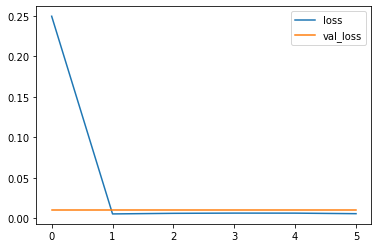

In [36]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

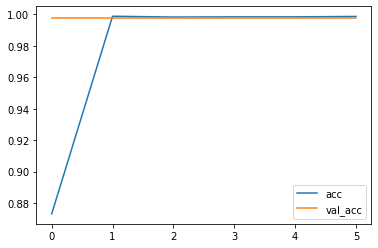

In [37]:
# Accuracy
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()

## テスト用データで予測

In [38]:
from tensorflow.keras.models import load_model
from keras_bert import get_custom_objects

# 学習中に保存した最良モデルをロード (tensorflow2.1ではエラーになります)
model = load_model(train_model_checkpoint_path, custom_objects=get_custom_objects())

# 予測を実行
y_test_pred_proba = model.predict([X_test, np.zeros_like(X_test)])

# 先頭3つのデータを表示
y_test_pred_proba[:3]

array([[5.0247269e-04, 9.9949753e-01],
       [6.9716328e-04, 9.9930286e-01],
       [9.9944466e-01, 5.5538520e-04]], dtype=float32)

### 結果レポート

In [39]:
from sklearn.metrics import classification_report, confusion_matrix

y_test_true_labels = y_test.argmax(axis=1) # Probability -> index
y_test_pred_labels = y_test_pred_proba.argmax(axis=1) # One-hot -> index

target_names = [index2label[i] for i in range(class_count)]
rep = classification_report(y_test_true_labels, y_test_pred_labels, target_names=target_names, output_dict=True)

pd.DataFrame(rep)

,MCI,Healthy,accuracy,macro avg,weighted avg
precision,0.995396,0.996276,0.995833,0.995836,0.995834
recall,0.996313,0.995349,0.995833,0.995831,0.995833
f1-score,0.995854,0.995812,0.995833,0.995833,0.995833
support,1085.000000,1075.000000,0.995833,2160.000000,2160.000000
